In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv(r"..\Dataset Preparation\FinalData.csv")
data.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR,Concentration
0,18_09_2024_2gSodium,01_Full,Degen,1270,0.011956,0.129460,0.0,0.0,0.0,0.0,...,1.138393,0.0,1.242808,1.196550,1.211091,1.044270,1.773443,0.983807,1.0,2030.110000
1,18_09_2024_2gSodium,01_Full,Degen,1271,0.009799,0.095385,0.0,0.0,0.0,0.0,...,1.138973,0.0,1.242930,1.196922,1.211649,1.042752,1.774462,0.980042,1.0,2022.796748
2,18_09_2024_2gSodium,01_Full,Degen,1272,0.011616,0.113608,0.0,0.0,0.0,0.0,...,1.139380,0.0,1.243419,1.196984,1.211622,1.036582,1.771977,0.982781,1.0,2015.548649
3,18_09_2024_2gSodium,01_Full,Degen,1273,0.009920,0.092299,0.0,0.0,0.0,0.0,...,1.138379,0.0,1.244232,1.196922,1.210374,1.038002,1.771729,0.985877,1.0,2008.365266
4,18_09_2024_2gSodium,01_Full,Degen,1274,0.009822,0.094579,0.0,0.0,0.0,0.0,...,1.138545,0.0,1.242483,1.197728,1.210693,1.047502,1.768001,0.984631,1.0,2001.246166


In [8]:
exp_name = list(data['Exp'].unique())

# Feature Engineering

## Feature Removal

In [3]:
insig_features = ['MinR','Q1R','MedR','Q3R','MinSig', 'PtsSig', 'MinRef','Q1Ref','MedRef','Q3Ref', 'MinIR', 'PtsIR']

In [92]:
df = data.copy()
df.drop(insig_features, axis=1, inplace=True)
features = list(df.columns)[4:-1]
target = 'Concentration'
print(len(features))

28


## Remove Outliers

- Exp0 and Exp4 outliers in IR data need to be removed

### Exp 1

In [93]:
impute_col = [col for col in features if "IR" in col] # All IR parameters column
impute_col

['MeanIR', 'VarIR', 'Q1IR', 'MedIR', 'Q3IR', 'MaxIR', 'SkewIR', 'KurtIR']

In [94]:
threshold = 1.14
row_index = df[(df['Exp'] == exp_name[0]) & (df['MeanIR'] < threshold)].index
l_ind = max(0, row_index[0] - 5)
r_ind = min(row_index[0] + 5, len(df))

In [95]:
df.loc[row_index[0], impute_col] = pd.concat([df.loc[l_ind:row_index[0]-1, impute_col], df.loc[row_index[0]+1:r_ind+1, impute_col]], axis=0).mean()

### Experiment 3

Raw length:  919
Thresholded length:  916


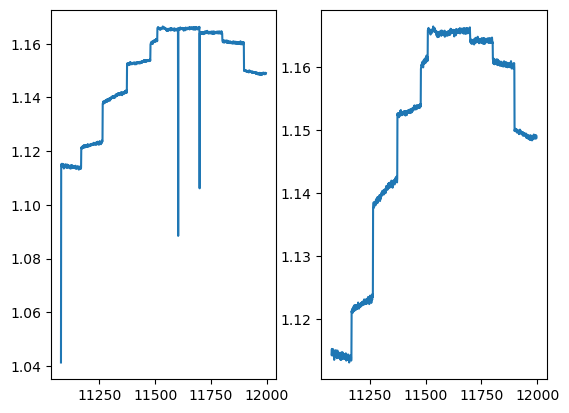

In [97]:
threshold = 1.11
plt.subplot(1,2,1)
df[(df['Exp'] == exp_name[3])]['MeanIR'].plot()
plt.subplot(1,2,2)
df[(df['Exp'] == exp_name[3]) & (df['MeanIR'] > threshold)]['MeanIR'].plot()
print("Raw length: ", len(df[(df['Exp'] == exp_name[3])]['MeanIR']))
print("Thresholded length: ", len(df[(df['Exp'] == exp_name[3]) & (df['MeanIR'] > threshold)]))

In [98]:
threshold = 1.11
exp = 3
row_index = df[(df['Exp'] == exp_name[exp]) & (df['MeanIR'] < threshold)].index
for ind in row_index:
    min_index = min(df[(df['Exp'] == exp_name[exp])].index)
    l_ind = max(min_index, ind - 5)
    r_ind = min(ind + 5, len(df))
    
    df.loc[ind, impute_col] = df.loc[ind, impute_col] = pd.concat([df[(df['Exp'] == exp_name[exp])].loc[l_ind:ind-1, impute_col], df[(df['Exp'] == exp_name[exp])].loc[ind+1:r_ind+1, impute_col]], axis=0).mean()

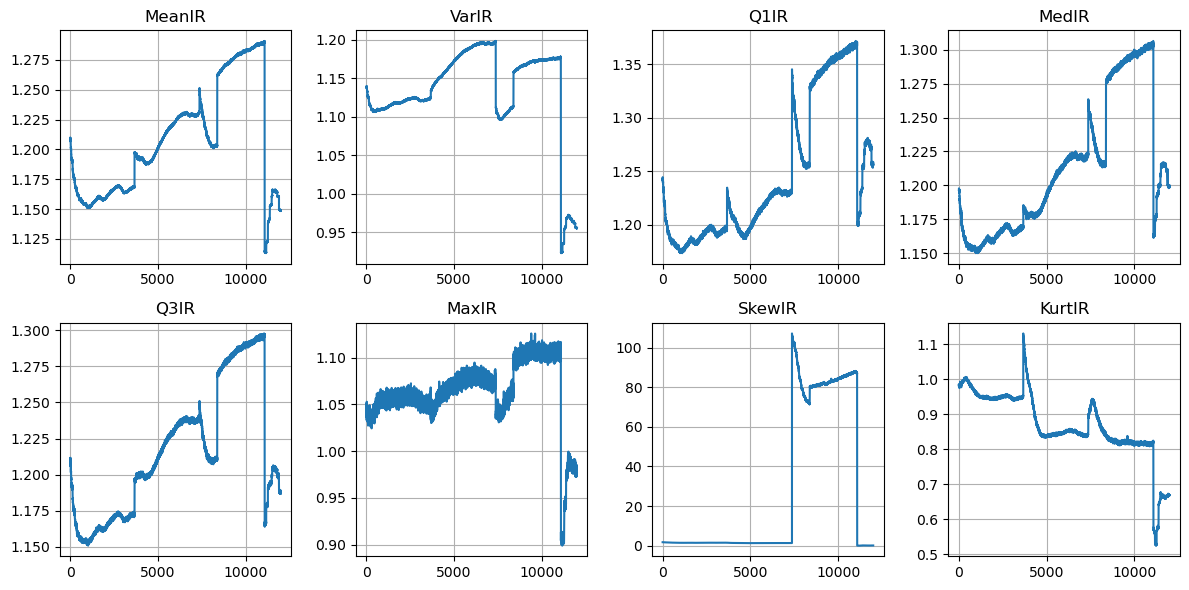

In [103]:
v_dim = 4
h_dim = math.ceil(len(impute_col) / v_dim)
fig, axes = plt.subplots(nrows=h_dim, ncols=v_dim, figsize=(12, 3 * h_dim))
for i, ax in enumerate(axes.flat):
    ax.plot(df[impute_col[i]])
    ax.set_title(impute_col[i])
    ax.grid(True)

plt.tight_layout()
plt.show()

In [127]:
df.to_csv("PreprocessedData.csv", index=False)

In [118]:
df[df['Exp'] != exp_name[3]].describe()

,Frame,MeanR,VarR,MaxR,SkewR,KurtR,PtsR,MeanSig,VarSig,Q1Sig,...,PtsRef,MeanIR,VarIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,Concentration
count,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,...,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000
mean,3152.610941,1.112619,1.045361,2.996542,1.854989,22.938773,1.286110,0.483326,0.442969,1.179423,...,0.788444,1.212241,1.149444,1.245469,1.213590,1.217974,1.070001,29.085622,0.889898,276.919669
std,1068.295653,0.533108,0.355570,3.821449,2.764869,122.805567,0.501304,0.173328,0.144853,0.168233,...,0.283135,0.044862,0.032000,0.066494,0.051074,0.046510,0.022355,39.152973,0.065947,368.177613
min,1250.000000,0.006696,0.081646,0.959736,0.725258,0.408787,0.011319,0.069868,0.048244,0.833333,...,0.007768,1.150860,1.095969,1.173433,1.150024,1.150919,1.024290,1.294032,0.808128,24.876361
25%,2229.250000,0.806384,0.874119,0.984457,0.972576,1.162910,1.034474,0.392540,0.356971,1.000000,...,0.692616,1.167386,1.118581,1.192516,1.167495,1.171153,1.052693,1.348139,0.836506,86.128316
50%,3152.500000,1.099225,1.029893,2.124737,1.132881,1.730981,1.402183,0.501531,0.474059,1.252900,...,0.813109,1.205471,1.158622,1.218390,1.207379,1.212100,1.064800,1.501495,0.853887,149.118215
75%,4075.750000,1.508254,1.258709,3.044867,1.404375,2.831194,1.662064,0.627135,0.560729,1.299304,...,0.980971,1.237502,1.175256,1.320039,1.252773,1.239869,1.085320,81.086442,0.947900,271.722580
max,5100.000000,2.050000,2.725902,83.266030,45.403459,2877.181787,1.968566,0.731435,0.655178,1.400000,...,1.151753,1.290754,1.198708,1.371713,1.306428,1.297677,1.125834,107.141990,1.131007,2030.110000


# Modeling

In [114]:
#Take only first 3 experiments
X = df[df['Exp'] != exp_name[3]][features]
y = df[df['Exp'] != exp_name[3]][target]

In [115]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=102)

In [120]:
## Scaling
scaler = RobustScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

## Linear Regression

In [122]:
lir = LinearRegression()
lir.fit(xtrain, ytrain)
ypred = lir.predict(xtest)
print("MSE: ", mean_squared_error(ytest, ypred))
print("Score: ", lir.score(xtest, ytest))

MSE:  3992.458766092572
Score:  0.9701219007944085


## Decision Tree

In [123]:
dt = DecisionTreeRegressor(random_state=102)
dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)
print("MSE: ", mean_squared_error(ytest, ypred))
print("Score: ", dt.score(xtest, ytest))

MSE:  65.47191157982705
Score:  0.9995100321921981


## Random Forest

In [125]:
rfm = RandomForestRegressor(random_state=102)
rfm.fit(xtrain, ytrain)
ypred = rfm.predict(xtest)
print("MSE: ", mean_squared_error(ytest, ypred))
print("Score: ", rfm.score(xtest, ytest))

MSE:  23.53812042618621
Score:  0.9998238493273419


## GBDT

In [126]:
gbr = GradientBoostingRegressor(random_state=102)
gbr.fit(xtrain, ytrain)
ypred = gbr.predict(xtest)
print("MSE: ", mean_squared_error(ytest, ypred))
print("Score: ", gbr.score(xtest, ytest))

MSE:  177.26669306110048
Score:  0.9986734009913619
